In [1]:
#Library imports
import re
import os
import time
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image, display
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


#User Created functions

from eda_functions import *
from modeling_functions import *

from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

#Notebook arguments
%matplotlib inline

In [2]:
#Device specific gpu deterministic arguments
from tensorflow import config as tfconfig
physical_devices = tfconfig.list_physical_devices('GPU')
tfconfig.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
#Sets random seeds to allow for reproducable results.
from tensorflow import random as tfrandom
SEED=127
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tfrandom.set_seed(SEED)

In [4]:
train_data = np.load("data/kuzushiji49/train/k49-train-imgs.npz")['arr_0']
train_labels = np.load("data/kuzushiji49/train/k49-train-labels.npz")['arr_0']
test_data = np.load("data/kuzushiji49/test/k49-test-imgs.npz")['arr_0']
test_labels = np.load("data/kuzushiji49/test/k49-test-labels.npz")['arr_0']
classmap = pd.read_csv("data/kuzushiji49/k49_classmap.csv")

In [7]:
full_value_counts(pd.DataFrame(train_labels), 0)

There are 49 unique values with 0 nan values making up 0.0%
6000-24 --2.58%
6000-27 --2.58%
6000-47 --2.58%
6000-21 --2.58%
6000-20 --2.58%
6000-19 --2.58%
6000-18 --2.58%
6000-17 --2.58%
6000-15 --2.58%
6000-12 --2.58%
6000-11 --2.58%
6000-10 --2.58%
6000-9 --2.58%
6000-7 --2.58%
6000-6 --2.58%
6000-5 --2.58%
6000-4 --2.58%
6000-2 --2.58%
6000-1 --2.58%
6000-25 --2.58%
6000-0 --2.58%
6000-28 --2.58%
6000-46 --2.58%
6000-30 --2.58%
6000-41 --2.58%
6000-40 --2.58%
6000-39 --2.58%
6000-38 --2.58%
6000-34 --2.58%
6000-35 --2.58%
6000-37 --2.58%
5132-26 --2.21%
4714-8 --2.03%
4165-13 --1.79%
3867-14 --1.66%
3523-48 --1.52%
3394-33 --1.46%
3060-31 --1.32%
2565-16 --1.10%
2451-23 --1.05%
2397-43 --1.03%
2139-42 --0.92%
2063-22 --0.89%
1993-29 --0.86%
1718-32 --0.74%
1598-36 --0.69%
777-3 --0.33%
417-44 --0.18%
392-45 --0.17%


In [4]:
classmap

,index,codepoint,char
0,0,U+3042,あ
1,1,U+3044,い
2,2,U+3046,う
3,3,U+3048,え
4,4,U+304A,お
5,5,U+304B,か
6,6,U+304D,き
7,7,U+304F,く
8,8,U+3051,け
9,9,U+3053,こ


In [37]:
imgs = [array_to_img(test_data[30].reshape([28,28,1])), "test", array_to_img(test_data[31].reshape([28,28,1]))]
display(*imgs)

'test'

In [20]:
classmap.iloc[test_labels[30]]

index            29
codepoint    U+307B
char              ほ
Name: 29, dtype: object

In [18]:
array_to_img(test_data[40].reshape([28,28,1]))

Label: 19


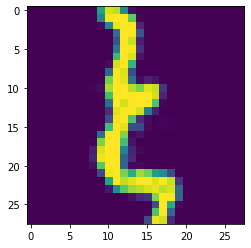

In [23]:
sample_image = test_data[0]
sample_label = test_labels[0]
display(plt.imshow(sample_image))
print('Label: {}'.format(sample_label))

In [5]:
def preprocess_raster_common(array, bits=8):
    X = array.copy()
    X = color_values_to_float(X, bits)
    return images_to_1d(X)

def preprocess_raster_pipeline(array, labels, bits=8, resample=None, random_state=None, test_size=None):
    X = preprocess_raster_common(array, bits)
    y = labels.copy()
    # If resampling is required, this will upsample the data unless the input string says "down"
    if resample:
        down = resample is "down"
        X, y = simple_resample_array(X, y, down=down, random_state=random_state)
    
    y = to_categorical(y)
    
    if test_size:
        return train_test_split(X, y, test_size=test_size, random_state=random_state)
    else:
        return X, y

In [6]:
X_train, X_val, y_train, y_val = preprocess_raster_pipeline(train_data, train_labels, resample="up", test_size=.2, random_state = SEED)
X_test, y_test = preprocess_raster_pipeline(test_data, test_labels)

In [7]:
model1 = Sequential()
model1.add(Dense(64, "tanh", input_shape=(784,)))
model1.add(Dense(49, activation='softmax'))

In [8]:
model1.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

In [9]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 49)                3185      
Total params: 53,425
Trainable params: 53,425
Non-trainable params: 0
_________________________________________________________________


In [10]:
results, test_metrics = [], []
for i in np.arange(0,6):
    result = model1.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))
    test_metric = model1.evaluate(X_test, y_test)
    results.append(result)
    test_metrics.append(test_metric)
    model1.save(f"model_backups/model1_{i}")

Train on 235200 samples, validate on 58800 samples
Epoch 1/5
235200/235200 [==============================] - 6s 25us/sample - loss: 2.3792 - accuracy: 0.4759 - val_loss: 1.7708 - val_accuracy: 0.5959
Epoch 2/5
235200/235200 [==============================] - 6s 25us/sample - loss: 1.6025 - accuracy: 0.6256 - val_loss: 1.4835 - val_accuracy: 0.6444
Epoch 3/5
235200/235200 [==============================] - 6s 25us/sample - loss: 1.4110 - accuracy: 0.6603 - val_loss: 1.3522 - val_accuracy: 0.6708
Epoch 4/5
235200/235200 [==============================] - 6s 24us/sample - loss: 1.3046 - accuracy: 0.6831 - val_loss: 1.2666 - val_accuracy: 0.6897
Epoch 5/5
38547/38547 [==============================] - 1s 32us/sample - loss: 1.8005 - accuracy: 0.5625
Test Loss: 1.8004744404264748, Test Accuracy: 0.5624821782112122
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_backups/model10/assets
Train on 235200 samples, validate

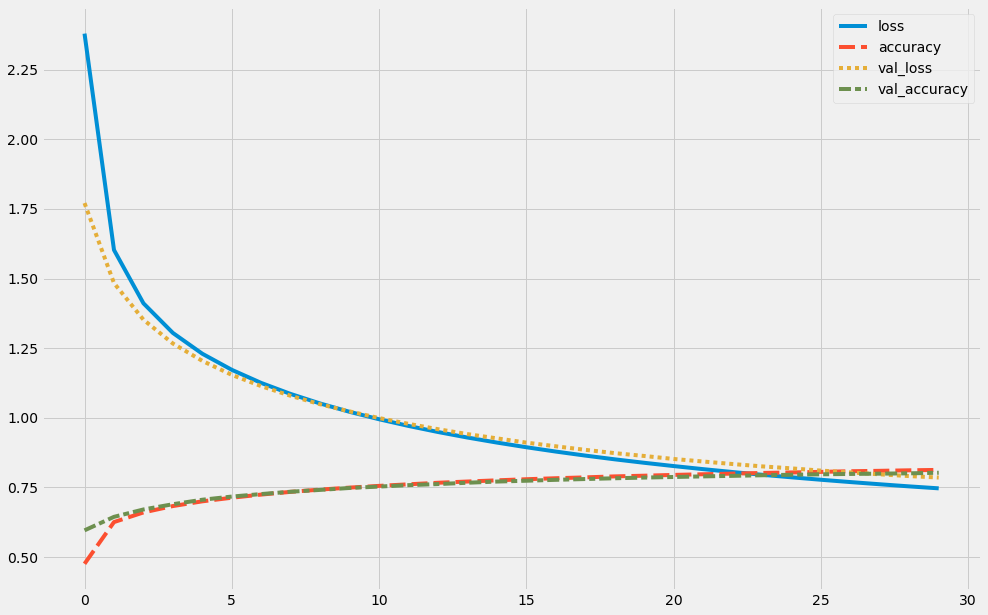

,loss,accuracy,val_loss,val_accuracy
0,2.379208,0.475850,1.770822,0.595884
1,1.602549,0.625604,1.483496,0.644405
2,1.410995,0.660255,1.352161,0.670833
3,1.304562,0.683133,1.266623,0.689728
4,1.229886,0.700106,1.204196,0.705816
5,1.172165,0.713010,1.154030,0.717194
6,1.125060,0.724345,1.113484,0.726224
7,1.085486,0.734107,1.078776,0.734558
8,1.051297,0.742253,1.048547,0.741122
9,1.021397,0.749358,1.022895,0.748078


In [11]:
plot_keras_fit_history(results, 0, common_plot_kwargs={"style": "fivethirtyeight"})

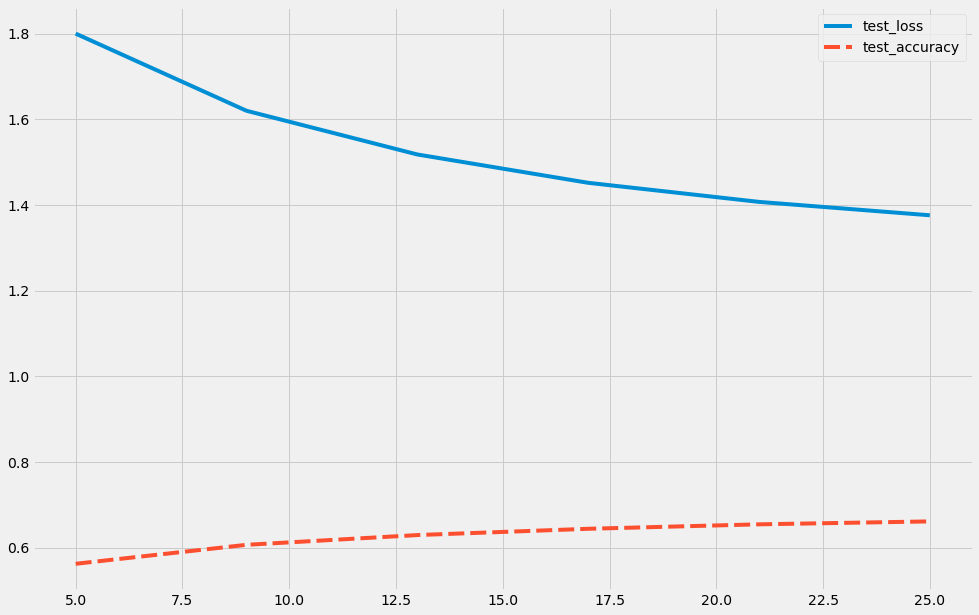

,test_loss,test_accuracy
5,1.800474,0.562482
9,1.620321,0.606792
13,1.518259,0.629543
17,1.452098,0.644227
21,1.407530,0.654629
25,1.376256,0.661452


In [12]:
plot_keras_test_evaluation(test_metrics, 5, 4, common_plot_kwargs={"style": "fivethirtyeight"})

In [17]:
model2 = Sequential()
model2.add(Dense(64, "tanh", input_shape=(784,)))
model2.add(Dense(56, activation='tanh'))
model2.add(Dense(49, activation='softmax'))
model2.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])
model2.summary()

In [20]:
results2, test_metrics2 = [], []
for i in np.arange(0,6):
    result = model2.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))
    test_metric = model2.evaluate(X_test, y_test)
    results2.append(result)
    test_metrics2.append(test_metric)
    model2.save(f"model_backups/model2_{i}")

Train on 235200 samples, validate on 58800 samples
Epoch 1/5
235200/235200 [==============================] - 6s 25us/sample - loss: 2.5061 - accuracy: 0.4416 - val_loss: 1.8277 - val_accuracy: 0.5837
Epoch 2/5
235200/235200 [==============================] - 6s 24us/sample - loss: 1.6169 - accuracy: 0.6211 - val_loss: 1.4733 - val_accuracy: 0.6459
Epoch 3/5
235200/235200 [==============================] - 6s 24us/sample - loss: 1.3774 - accuracy: 0.6660 - val_loss: 1.3051 - val_accuracy: 0.6801
Epoch 4/5
235200/235200 [==============================] - 6s 24us/sample - loss: 1.2390 - accuracy: 0.6953 - val_loss: 1.1944 - val_accuracy: 0.7057
Epoch 5/5
38547/38547 [==============================] - 1s 32us/sample - loss: 1.7071 - accuracy: 0.5826
Test Loss: 1.7070775213886564, Test Accuracy: 0.582587480545044
INFO:tensorflow:Assets written to: model_backups/model2_0/assets
Train on 235200 samples, validate on 58800 samples
Epoch 1/5
235200/235200 [==============================] - 6s 2

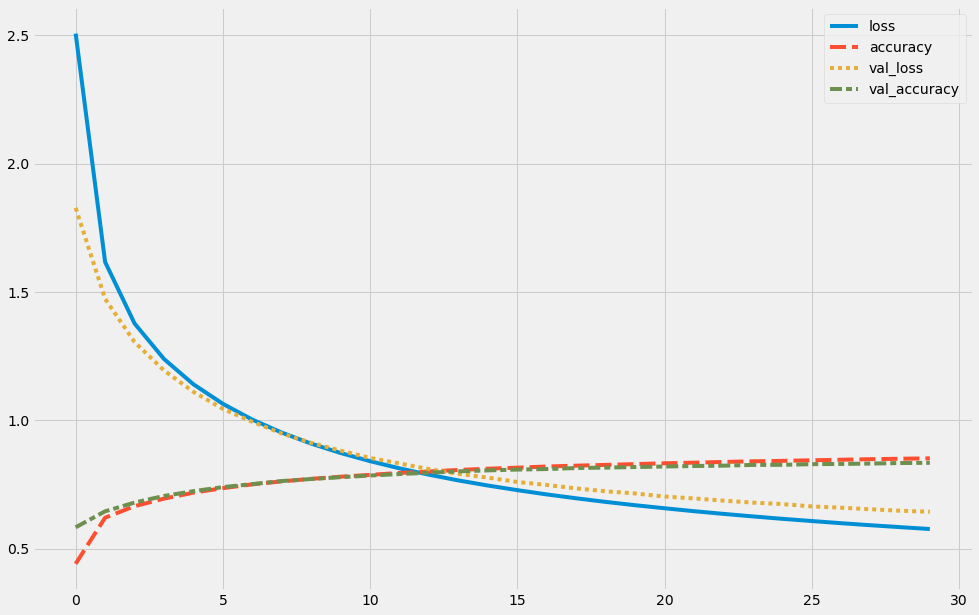

,loss,accuracy,val_loss,val_accuracy
0,2.506141,0.441586,1.827728,0.583656
1,1.616945,0.621084,1.473286,0.645935
2,1.377370,0.666008,1.305065,0.680085
3,1.239048,0.695293,1.194392,0.705748
4,1.140400,0.718588,1.111033,0.724439
5,1.064400,0.736080,1.044772,0.740204
6,1.002901,0.750940,0.994356,0.751990
7,0.952358,0.762509,0.948813,0.763776
8,0.909368,0.772351,0.912475,0.771752
9,0.872818,0.780795,0.882026,0.778929


In [25]:
plot_keras_fit_history(results2, 0, common_plot_kwargs={"style": "fivethirtyeight"})

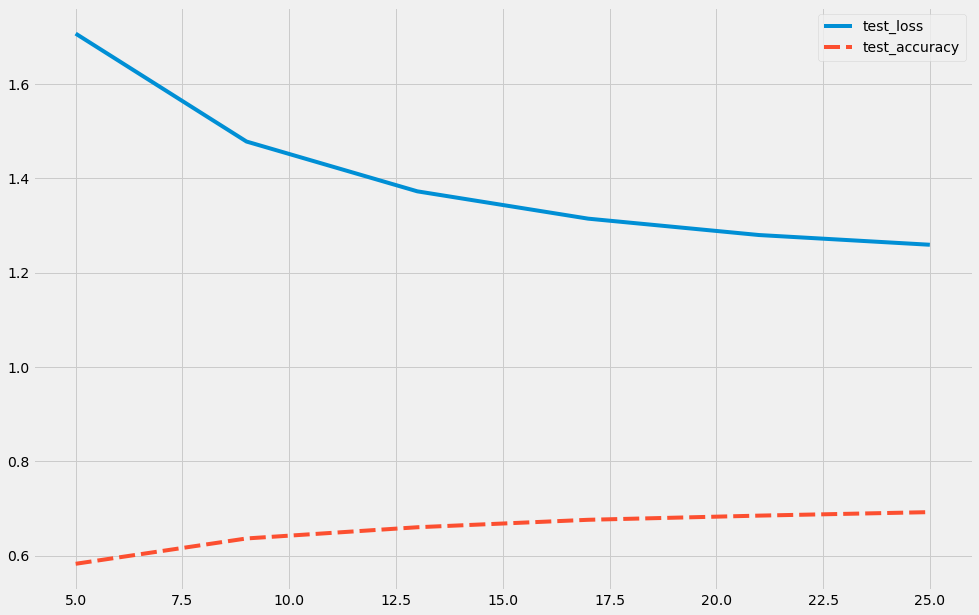

,test_loss,test_accuracy
5,1.707078,0.582587
9,1.478183,0.636314
13,1.372544,0.660103
17,1.314594,0.675902
21,1.279869,0.684748
25,1.259240,0.692168


In [26]:
plot_keras_test_evaluation(test_metrics2, 5, 4, common_plot_kwargs={"style": "fivethirtyeight"})

In [24]:
model3 = Sequential()
model3.add(Dense(64, "relu", input_shape=(784,)))
model3.add(Dense(56, activation='relu'))
model3.add(Dense(49, activation='softmax'))
model3.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_12 (Dense)             (None, 56)                3640      
_________________________________________________________________
dense_13 (Dense)             (None, 49)                2793      
Total params: 56,673
Trainable params: 56,673
Non-trainable params: 0
_________________________________________________________________


In [27]:
results3, test_metrics3 = [], []
for i in np.arange(0,6):
    result = model3.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))
    test_metric = model3.evaluate(X_test, y_test)
    results3.append(result)
    test_metrics3.append(test_metric)
    model3.save(f"model_backups/model3_{i}")

Train on 235200 samples, validate on 58800 samples
Epoch 1/5
235200/235200 [==============================] - 6s 25us/sample - loss: 2.3925 - accuracy: 0.4300 - val_loss: 1.5793 - val_accuracy: 0.6107
Epoch 2/5
235200/235200 [==============================] - 6s 24us/sample - loss: 1.4160 - accuracy: 0.6492 - val_loss: 1.3036 - val_accuracy: 0.6756
Epoch 3/5
235200/235200 [==============================] - 6s 24us/sample - loss: 1.2077 - accuracy: 0.6981 - val_loss: 1.1415 - val_accuracy: 0.7146
Epoch 4/5
235200/235200 [==============================] - 6s 24us/sample - loss: 1.0782 - accuracy: 0.7290 - val_loss: 1.0359 - val_accuracy: 0.7407
Epoch 5/5
38547/38547 [==============================] - 1s 33us/sample - loss: 1.5588 - accuracy: 0.6211
Test Loss: 1.558771714136338, Test Accuracy: 0.6211378574371338
INFO:tensorflow:Assets written to: model_backups/model3_0/assets
Train on 235200 samples, validate on 58800 samples
Epoch 1/5
235200/235200 [==============================] - 6s 2

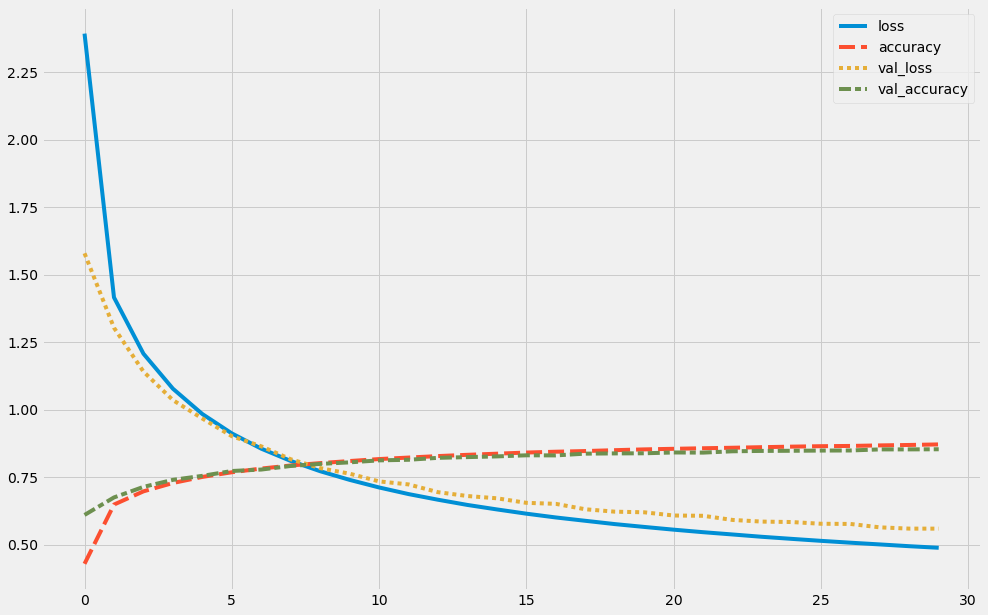

,loss,accuracy,val_loss,val_accuracy
0,2.392541,0.429962,1.579280,0.610714
1,1.415972,0.649167,1.303588,0.675595
2,1.207676,0.698078,1.141465,0.714643
3,1.078189,0.729031,1.035861,0.740680
4,0.984311,0.751548,0.967691,0.755476
5,0.912621,0.768758,0.902307,0.773435
6,0.856156,0.782487,0.864778,0.778810
7,0.810682,0.793882,0.816906,0.792058
8,0.772650,0.802632,0.784110,0.799711
9,0.740617,0.810357,0.763513,0.805459


In [28]:
plot_keras_fit_history(results3, 0, common_plot_kwargs={"style": "fivethirtyeight"})

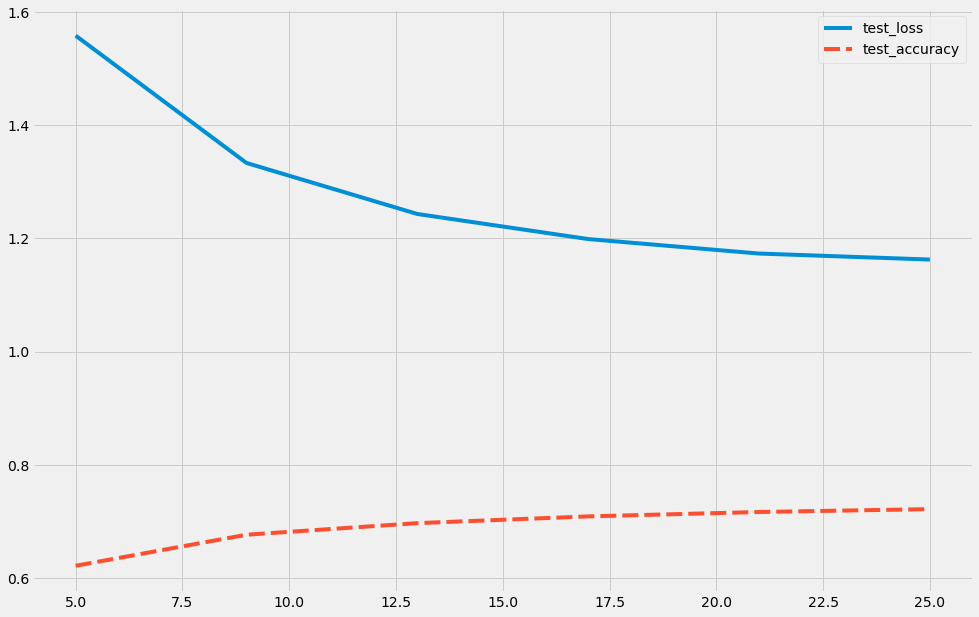

,test_loss,test_accuracy
5,1.558772,0.621138
9,1.333544,0.676058
13,1.243314,0.696552
17,1.198985,0.708486
21,1.173340,0.716268
25,1.162723,0.721353


In [29]:
plot_keras_test_evaluation(test_metrics3, 5, 4, common_plot_kwargs={"style": "fivethirtyeight"})